# 2018 IAAF World Half Marathon Championship Prediction

by Ruofan Lyu (lyu.ru@husky.neu.edu)

## Introduction

IAAF World Half Marathon Championship will be held in Valencia, Spain this year. It is an annual half marathon competition organized by the International Association of Athletics Federations, generally held every October. 

Prediction of this competition can provide a foresee to either athlete and audience. For the athletes, they could determine their further training strategy based on the prediction; for the audience, they would be more interested in the game, once the event draws more public attention, it will create more economic and cultural values.

This project has mainly two parts of work: web scraping and machine learning modeling.

## Web Scraping

### Imports

In [1]:
from __future__ import print_function
import urllib3 #  pip install -i https://pypi.anaconda.org/pypi/simple urllib3
import unicodedata
import datetime
from bs4 import BeautifulSoup, SoupStrainer, Comment
import warnings
import requests
warnings.filterwarnings('ignore')

# Create two lists to store original urls and redirected links
urls = []
links = []

### Get All The Athletes' Profile URLs

In [2]:
# URL of the atheletes list
url = 'https://www.iaaf.org/athletes/search?name=&country=&discipline=half-marathon&gender=men'

Create a response based on the http request and get the status of the url.

In [3]:
http = urllib3.PoolManager()
response = http.request('GET',url)
response.status

200

Response code 200:  ('OK', 'Request fulfilled, document follows')

Create a BeautifulSoup object and call find_all() function to find all the "a" tags to get all links in the web page.

In [4]:
soup=BeautifulSoup(response.data, "lxml")

Loop through all the "a" tags in the page and estimate the url to see if it contains partial string like "/athletes/athlete=". If so, that means this is an internal link, store it into urls list; if not, drop it.

In [5]:
for link in soup.find_all('a',href = True):
    href = link.get('href')
    if "/athletes/athlete=" in href:
        href = "https://www.iaaf.org" + link.get('href')
    else:
        href = None
    if href != None:
        urls.append(href)
#         print(href)
print('Sample url:',urls[0])
print('Sample url:',urls[1])
print(len(urls))

Sample url: https://www.iaaf.org/athletes/athlete=273114
Sample url: https://www.iaaf.org/athletes/athlete=325829
5773


Loop through urls list, use the get() method in requests to get the redirected url(which is eligible to crwaling data) and add them into a new list links[].

Note this process may take longer.

In [6]:
# identify user agent to get access to the GET request
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.167 Safari/537.36'}
for i in urls:
    rs = requests.get(i,headers = headers).url
    links.append(rs)
print('Sample link:',links[0])
print('Sample link:',links[1])
print(len(links))

Sample link: https://www.iaaf.org/athletes/great-britain-ni/mohamud-ibrahim-aadan-273114
Sample link: https://www.iaaf.org/athletes/morocco/abden-naser-aamar-325829
5773


Write the urls in links list into a .csv file for further use.

In [7]:
import csv
csvfile = 'linkList.csv'

with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in links:
        writer.writerow([val])

### Get All The Athletes' Profile

In [8]:
# import re package to estimate the formats inside HTML
import re
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

Load the links as a pandas dataframe in the file we just created above.

In [9]:
import pandas as pd
df = pd.read_csv("linkList.csv", header=None)

This is the function to take a url string value and get the returned list from 'Records' and append them into a new list result_total.

In [10]:
import requests

def athleteList(url): 
    result_total = []
    if records(url) != None:
        #   Add a single record of informaiton to total
        result_total.extend(records(url))

    return result_total

This function is to take an url string and extract the contents in the url based on it's html structure using BeautifulSoup.

First, create a response of the url and using soup to find out the disciplines number and the records number under the disciplines. Create a result list to store the records.

Then, loop through the number of disciplines. Inside each discipline loop, loop through the number of records in this discipline and crawl the performance, place and date of the record.

Third, wrap the performance, place and date of the record with its corresponding discipline, together with the name, date of birth and IAAF code on the page, into a complete single record, store these features into the results list and return. 

In [11]:
def records(url):
    http = urllib3.PoolManager()
    response = http.request('GET',url)
    soup = BeautifulSoup(response.data,'html.parser')
    
    # Find the records in "PROGRESSION" tag
    if soup.find('div',attrs ={'id':'progression'}):
        # Find the number of disciplines inside the current progression tag by count the number of <div> tags which the class is 'container offset-below'
        dcpl_num = len(soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'}))
        #Iinitialize the total record number to 0 under the discipline
        rec_num = 0
        # Create a list to store records in each dicipline
        rec_num_in_dcpl = []
    
        # Loop through dicipline number and find out the corresponding record number under each discipline
        for i in range(dcpl_num):
            # Add the number of records in each discipline into records number list in sequence
            rec_num_in_dcpl.append(len(soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('table',attrs ={'class':'records-table'}).find('tbody').find_all('tr')))
            # Add total records number
            rec_num = rec_num + len(soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('table',attrs ={'class':'records-table'}).find('tbody').find_all('tr'))
    
        # Create a list to store all the records in current
        results = []
        # Loop through each dicipline
        for i in range(dcpl_num):
            # Loop through each record
            for j in range(rec_num_in_dcpl[i]):
                # Create a dictionary to store single information record
                result = {}
                # Find athlete's name inside <title> tag
                name = soup.find("title").get_text().replace('\n        ', '').split(' |')[0]
                # Add name to current record list
                result['Name'] = name
            
                spanTags0 = soup.find('span',attrs ={'class':'_label _label--athlete-id'})
                if spanTags0:
                    code = soup.find('span',attrs ={'class':'_label _label--athlete-id'}).get_text().replace('\n', '').replace(' ','').replace("ATHLETE'SIAAFCODE", '')
                else:
                    no_code = url.split('-')
                    code = no_code[len(no_code)-1]
                # Add IAAF code to current record list
                result['IAAF_code'] = code
                            
                liTags0 = soup.find('li',attrs ={'class':'no-after athlete__details'})
                if liTags0:
                    dob = soup.find('li',attrs ={'class':'no-after athlete__details'}).find('span',attrs ={'class':'_label'}).get_text().replace('\n', '').replace(' ','').replace("DATEOFBIRTH", '')
                # Use regular expression to transfer the DOB format
                # dob = re.findall('\d+|\D+', dob)[0]+ '-' + re.findall('\d+|\D+', dob)[1] + '-' + re.findall('\d+|\D+', dob)[2]
                else:
                    dob = soup.find('li',attrs ={'class':'no-after'}).find('span',attrs ={'class':'_label'}).get_text().replace('\n', '').replace(' ','').replace("DATEOFBIRTH", '')
                # Add date of birth to current record list
                result['Date_of_birth'] = dob
            
                dcpl = soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('h2').get_text().replace('\n', '').replace('View Graph','').replace(' ','')
                # Add discipline to current record list
                result['Discipline'] = dcpl
            
                performance = soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('table').find('tbody').find_all('tr')[j].find('td',attrs ={'data-th':'Performance'}).get_text().replace('\n', '').replace(' ','')
                # Add performance to current record list
                result['Performance'] = performance
            
                place = soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('table').find('tbody').find_all('tr')[j].find('td',attrs ={'data-th':'Place'}).get_text().lstrip('\n          ').rstrip('\n        ')
                # Add place to current record list
                result['Place'] = place
            
                date = soup.find('div',attrs ={'id':'progression'}).find_all('div',attrs ={'class':'container offset-below'})[i].find('table').find('tbody').find_all('tr')[j].find('td',attrs ={'data-th':'Date'}).get_text().replace('\n', '').replace(' ','')
                # Add date to current record list
                result['Date'] = date
                
                # Add current record to the results list as a single record
                results.append(result)
        return results

Create a list, loop through each url and call the athleteList function, append all the records from all athletes into atlete_total list, then store the list to a .csv file file for future use.

Note this process may take several hours to get all the data.

In [12]:
athlete_total = []

for i in range(len(df)):
    url = df.loc[i][0]
    athlete_result = athleteList(url)
    athlete_total.extend(athlete_result)

df2 = pd.DataFrame(athlete_total)
print(df2.head)

df2.to_csv('athletes.csv')

<bound method NDFrame.head of              Date Date_of_birth    Discipline IAAF_code  \
0       15JUL2017     01JAN1990    3000Metres    273114   
1       07MAY2016     01JAN1990    3000Metres    273114   
2       09MAY2015     01JAN1990    3000Metres    273114   
3       09AUG2014     01JAN1990    3000Metres    273114   
4       08JUN2013     01JAN1990    3000Metres    273114   
5       22JUL2017     01JAN1990    5000Metres    273114   
6       23JUL2016     01JAN1990    5000Metres    273114   
7       18JUL2015     01JAN1990    5000Metres    273114   
8       07JUN2014     01JAN1990    5000Metres    273114   
9       17AUG2013     01JAN1990    5000Metres    273114   
10      25AUG2012     01JAN1990    5000Metres    273114   
11      20MAY2017     01JAN1990  10,000Metres    273114   
12      21MAY2016     01JAN1990  10,000Metres    273114   
13      07SEP2013     01JAN1990  10Kilometres    273114   
14      24MAR2018     01JAN1990  HalfMarathon    273114   
15      18JAN2015     01JA

### Get Participated Athletes' List

In [13]:
import requests
import csv
import json
import sys
import codecs

from urllib.request import urlopen;  

In [14]:
# URL of the participated athletes
url = 'https://www.iaaf.org/data/athletesatevent/6023'
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.167 Safari/537.36'}

The athlete list is scraping from the 2018 IAAF world half marathon championship official website. This list is in JSON form, so I have to process and save it as a .csv file then join it with the athlete performance history to get the valid data.

In [15]:
# Read and decode the json file
rawtext=urlopen(url,timeout=15).read();  
jsonStr = json.loads(rawtext.decode('utf8')); 

print('Sample JSON text:',jsonStr[0])
print('Sample JSON text:',jsonStr[1])

Sample JSON text: {'id': 273114, 'fn': 'Mohamud Ibrahim', 'ln': 'Aadan', 'Cty': 'Great Britain & N.I.', 'CC': 'GBR', 'DOB': '01 JAN 1990', 'S': 'Men', 'D': [{'N': 'Half Marathon', 'DC': 'HMAR'}], 'frn': 'Aadan', 'pb': None, 'sb': None, 'fl': 'A', 'cf': None, 'TeamName': None, 'SexNameShow': None, 'CompetitiorId': 0, 'EventId': 0}
Sample JSON text: {'id': 369352, 'fn': 'Nesma Ammar Saad Mohamed', 'ln': 'Abdelghany', 'Cty': 'Egypt', 'CC': 'EGY', 'DOB': '01 JAN 1993', 'S': 'Women', 'D': [{'N': 'Half Marathon', 'DC': 'HMAR'}], 'frn': 'Abdelghany', 'pb': None, 'sb': None, 'fl': 'A', 'cf': None, 'TeamName': None, 'SexNameShow': None, 'CompetitiorId': 0, 'EventId': 0}


In [16]:
# Save the JSON to local
f=open("jsondatafile.json","a",encoding="utf8");
f.write(json.dumps(jsonStr,ensure_ascii=False)+"\n");
f.close();

In [17]:
# Read local JSON file to see if it has been saved correctly
for eachLine in open("jsondatafile.json","r",encoding="utf8"):  
    jsonData=json.loads(eachLine);
print('Sample data read:',jsonData[0]) 

Sample data read: {'id': 273114, 'fn': 'Mohamud Ibrahim', 'ln': 'Aadan', 'Cty': 'Great Britain & N.I.', 'CC': 'GBR', 'DOB': '01 JAN 1990', 'S': 'Men', 'D': [{'N': 'Half Marathon', 'DC': 'HMAR'}], 'frn': 'Aadan', 'pb': None, 'sb': None, 'fl': 'A', 'cf': None, 'TeamName': None, 'SexNameShow': None, 'CompetitiorId': 0, 'EventId': 0}


In [18]:
# Save each id into a list
i = 0
idList = []
for di in jsonData:
    idList.append(jsonData[i]['id'])
    i = i + 1

In [19]:
# Save athletes' ids into .csv file
csvfile = 'idList.csv'
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in idList:
        writer.writerow([val])

## Data Cleaning

Import spark packages.

In [20]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

Create a spark sql context.

In [21]:
from pyspark.sql.types import *

sc = spark.sparkContext

Set up a spark structured streaming with columns' name and proper data type.

Show the sample data in the dataframe.

In [22]:
# Load data to dataframe
dataSchema = StructType([StructField('Record_No', IntegerType(), True),
                     StructField('Date', StringType(), True),
                     StructField('Date_of_birth', StringType(), True),
                     StructField('Discipline', StringType(), True),
                     StructField('IAAF_code', IntegerType(), True),
                     StructField('Name', StringType(), True),
                     StructField('Performance', StringType(), True),
                     StructField('Place', StringType(), True)])

performanceData = spark.read.csv('athletes.csv', header=True, schema=dataSchema)
display(performanceData.head(5))

[Row(Record_No=0, Date='15JUL2017', Date_of_birth='01JAN1990', Discipline='3000Metres', IAAF_code=273114, Name='Mohamud Ibrahim AADAN', Performance='8:13.12', Place='Bedford (GBR)'),
 Row(Record_No=1, Date='07MAY2016', Date_of_birth='01JAN1990', Discipline='3000Metres', IAAF_code=273114, Name='Mohamud Ibrahim AADAN', Performance='8:15.56', Place='Watford (GBR)'),
 Row(Record_No=2, Date='09MAY2015', Date_of_birth='01JAN1990', Discipline='3000Metres', IAAF_code=273114, Name='Mohamud Ibrahim AADAN', Performance='8:18.86', Place='Crawley (GBR)'),
 Row(Record_No=3, Date='09AUG2014', Date_of_birth='01JAN1990', Discipline='3000Metres', IAAF_code=273114, Name='Mohamud Ibrahim AADAN', Performance='8:25.44', Place='Lee Valley (GBR)'),
 Row(Record_No=4, Date='08JUN2013', Date_of_birth='01JAN1990', Discipline='3000Metres', IAAF_code=273114, Name='Mohamud Ibrahim AADAN', Performance='8:25.58', Place='Wormwood Scrubs (GBR)')]

Import pyspark sql functions.

In [23]:
from pyspark.sql.functions import *

Call count() method to see how many distinct disciplines are there in the data.

In [24]:
performanceData.select("Discipline").distinct().count()

55

There are total 55 disciplines in the dataset, including the non-running competitions, so I need to filter the data and get the records of running races.

Create a filter dataframe to filter the original data and get only the records of running races.

In [25]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Create a new dataframe to filter the dicipline
dspl = [(0,'20,000Metres'),(1,'3000Metres'),(2,'20Kilometres'),(3,'12Kilometres'),(4,'30Kilometres'),(5,'2000Metres'),(6,'8Kilometres'),(7,'OneMile'),(8,'1500Metres'),(9,'5Kilometres'),(10,'10Kilometres'),(11,'15Kilometres'),(12,'TwoMiles'),(13,'Marathon'),(14,'HalfMarathon'),(15,'25Kilometres'),(16,'5000Metres'),(17,'10,000Metres'),(18,'1000Metres')]
columns = ['No_','Discipline' ]
discipline = sqlContext.createDataFrame(dspl, columns)

Join the original data with the filter and get a new dataset including all running races data.

Show the distinct disciplines now and count the number of distinct disciplines.

In [26]:
# Join the profile data with the filter
performanceData = performanceData.join(discipline, "Discipline")
performanceData.select("Discipline").distinct().show()
performanceData.select("Discipline").distinct().count()

+------------+
|  Discipline|
+------------+
|20,000Metres|
|  3000Metres|
|20Kilometres|
|12Kilometres|
|30Kilometres|
|  2000Metres|
| 8Kilometres|
|     OneMile|
|  1500Metres|
| 5Kilometres|
|10Kilometres|
|15Kilometres|
|    TwoMiles|
|    Marathon|
|HalfMarathon|
|25Kilometres|
|  5000Metres|
|10,000Metres|
|  1000Metres|
+------------+



19

Now, there are total 19 disciplines, running races only.

Load the participated athletes' id data and make it a dataframe to use after.

In [27]:
# Load id data to dataframe
dataSchema_id = StructType([StructField('IAAF_code', IntegerType(), True)])

idData = spark.read.csv('idList.csv', header=False, schema=dataSchema_id)
idData.count()

281

Select useful information in the records and make it a new dataframe ordered by the default record number.

In [28]:
performanceData = performanceData.select('Record_No','IAAF_code','Name','Date_of_birth', 'Date','Place','Discipline','Performance').orderBy(performanceData['Record_No'])

User-defined function to transfer the multiple format of performance time in the dataframe to Milliseconds, which will be more convenient to build the model.

There're several types of format for the "Performance" column, for example: "8:15.6", "1:09:41", "30:34:00", etc. Each of these formats are hard to make use of building the model. So I wrote the function which is adaptive to all the time formats in this dataset to transfer to milliseconds.

I used regular expression to estimate the format of time and calculate the corresponding milliseconds.

The function returns an millisecond integer.

In [29]:
import datetime
import re
# @udf
def timeTransfer(time_str):
    if '.' in time_str:
        r1 = re.compile('^\d{1}:\d{2}\.\d{2}')
        r2 = re.compile('^\d{2}:\d{2}\.\d{2}')
        r3 = re.compile('^\d{2}:\d{2}:\d{2}\.\d{2}')
        if r1.match(time_str) is not None:
            time = datetime.datetime.strptime(time_str, "%M:%S.%f")
            return int(time.minute) * 60000 +int(time.second) * 1000 +int(time.microsecond)/1000
        elif r2.match(time_str) is not None:
            time = datetime.datetime.strptime(time_str, "%M:%S.%f")
            return int(time.minute) * 60000 +int(time.second) * 1000 +int(time.microsecond)/1000
        elif r3.match(time_str) is not None:
            time = datetime.datetime.strptime(time_str, "%H:%M:%S.%f")
            return int(time.hour) * 3600000 + int(time.minute) * 60000 +int(time.second) * 1000 +int(time.microsecond)/1000
    else:
        r4 = re.compile('^\d{2}:\d{2}')
        r5 = re.compile('^\d{1}:\d{2}:\d{2}')
        if r4.match(time_str) is not None:
            time = datetime.datetime.strptime(time_str, "%M:%S")
            return int(time.minute) * 60000 +int(time.second) * 1000
        elif r5.match(time_str) is not None:
            time = datetime.datetime.strptime(time_str, "%H:%M:%S")
            return int(time.hour) * 3600000 + int(time.minute) * 60000 +int(time.second) * 1000

In [30]:
# Register the function
sqlContext.udf.register("timeTransfer", timeTransfer)
timeTransfer_udf = udf(timeTransfer)

User-defined function to get the month in 'Date' column.

Estimate the string inside the "Date" column and returns the corresponding month integer.

In [31]:
def convert_month(date_str):
    if 'JAN' in date_str:
        return 1
    elif 'FEB' in date_str:
        return 2
    elif 'MAR' in date_str:
        return 3
    elif 'APR' in date_str:
        return 4
    elif 'MAY' in date_str:
        return 5
    elif 'JUN' in date_str:
        return 6
    elif 'JUL' in date_str:
        return 7
    elif 'AUG' in date_str:
        return 8
    elif 'SEP' in date_str:
        return 9
    elif 'OCT' in date_str:
        return 10
    elif 'NOV' in date_str:
        return 11
    elif 'DEC' in date_str:
        return 12
    return date_str.month

In [32]:
# Register the function
sqlContext.udf.register("convert_month", convert_month)
convert_month_udf = udf(convert_month)

User-defined function to transfer the original dicipline to race length in metres.

Estimate the string inside the "Discipline" column and returns the corresponding metre integer.

In [33]:
def event_convert(event_str):
    if "20,000Metres" in event_str:
        return 20000
    elif "3000Metres" in event_str:
        return 3000
    elif "20Kilometres" in event_str:
        return 20000
    elif "12Kilometres" in event_str:
        return 12000
    elif "30Kilometres" in event_str:
        return 30000
    elif "2000Metres" in event_str:
        return 2000
    elif "8Kilometres" in event_str:
        return 8000
    elif "OneMile" in event_str:
        return 1609
    elif "1500Metres" in event_str:
        return 1500
    elif "5Kilometres" in event_str:
        return 5000
    elif "10Kilometres" in event_str:
        return 10000
    elif "15Kilometres" in event_str:
        return 15000
    elif "TwoMiles" in event_str:
        return 3219
    elif "25Kilometres" in event_str:
        return 25000
    elif "HalfMarathon" in event_str:
        return 21098
    elif "Marathon" in event_str:
        return 42195
    elif "5000Metres" in event_str:
        return 5000
    elif "10,000Metres" in event_str:
        return 10000
    elif "1000Metres" in event_str:
        return 1000

In [34]:
# Register the function
sqlContext.udf.register("event_convert", event_convert)
event_convert_udf = udf(event_convert)

User-defined function to get the age when athelte attend the race.

Get the last 4 digits in "Date" and "Date_of_birth" column and calculate the different value between them to get the age of the athlete when he attend the race.

In [35]:
def ageTransfer(year1,year2):
    year1 = int(year1[-4:])
    year2 = int(year2[-4:])
    return year1 - year2

In [36]:
# Register the function
sqlContext.udf.register("ageTransfer", ageTransfer)
ageTransfer_udf = udf(ageTransfer)

Using the three functions above to add three new columns into the dataframe based on the original values. They are: 

- 'perf_millisecs' : Performance to milliseconds

- 'month' : month of the race took place

- 'race_metre' : metre of the race

- 'age' : age of athlete

In [39]:
performanceData = performanceData.where(performanceData['Discipline'] == 'HalfMarathon').select('Record_No','IAAF_code','Name','Date_of_birth', 'Date','Place','Discipline','Performance',timeTransfer_udf('Performance').alias('perf_millisecs'),convert_month_udf('Date').alias('month'),event_convert_udf('Discipline').alias('race_metre'))

Drop rows contains null values, which may influence the model building.

In [40]:
performanceData_train = performanceData.dropna()
performanceData_train = performanceData_train.select('Record_No','IAAF_code','Name','Date_of_birth', 'Date','Place','Discipline','Performance','perf_millisecs','month','race_metre',ageTransfer_udf('Date','Date_of_birth').alias('age'))
performanceData_train.show()

+---------+---------+--------------------+-------------+---------+--------------------+------------+-----------+--------------+-----+----------+---+
|Record_No|IAAF_code|                Name|Date_of_birth|     Date|               Place|  Discipline|Performance|perf_millisecs|month|race_metre|age|
+---------+---------+--------------------+-------------+---------+--------------------+------------+-----------+--------------+-----+----------+---+
|       14|   273114|Mohamud Ibrahim A...|    01JAN1990|24MAR2018|      Valencia (ESP)|HalfMarathon|    1:02:34|       3754000|    3|     21098| 28|
|       21|   325829|   Abden Naser AAMAR|         1986|29JAN2017|     Marrakesh (MAR)|HalfMarathon|    1:09:41|       4181000|    1|     21098| 31|
|       22|   325829|   Abden Naser AAMAR|         1986|31JAN2016|     Marrakesh (MAR)|HalfMarathon|    1:09:37|       4177000|    1|     21098| 30|
|       23|   325829|   Abden Naser AAMAR|         1986|25JAN2015|     Marrakesh (MAR)|HalfMarathon|    1:

In [41]:
performanceData_train=performanceData_train.withColumn("perf_millisecs", performanceData_train["perf_millisecs"].cast(IntegerType())).withColumn("month", performanceData_train["month"].cast(IntegerType())).withColumn("race_metre", performanceData_train["race_metre"].cast(IntegerType())).withColumn("age", performanceData_train["age"].cast(IntegerType()))
performanceData_train.printSchema()

root
 |-- Record_No: integer (nullable = true)
 |-- IAAF_code: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date_of_birth: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Place: string (nullable = true)
 |-- Discipline: string (nullable = true)
 |-- Performance: string (nullable = true)
 |-- perf_millisecs: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- race_metre: integer (nullable = true)
 |-- age: integer (nullable = true)



Import seaborn and matplotlib packages to visualize the data, draw a graph of the relationship between performance and discipline.

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
# Transfer spark dataframe to pandas dataframe in order to visualize data
visual = performanceData_train.toPandas()

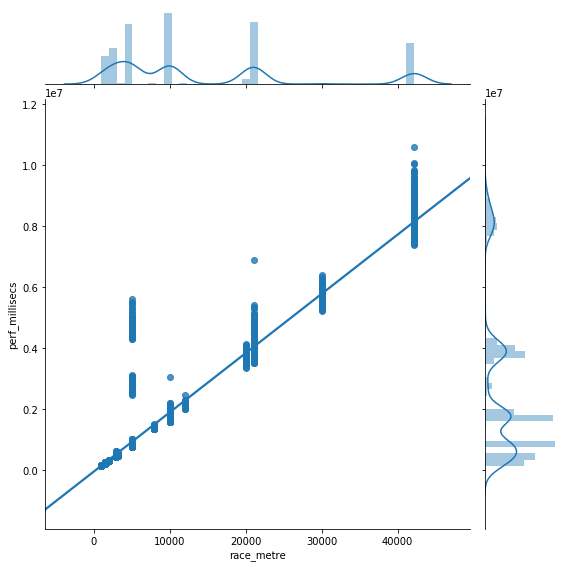

In [22]:
g = sns.JointGrid(x="race_metre", y="perf_millisecs", size=8, data=visual)
g.set_axis_labels("race_metre", "perf_millisecs")
g = g.plot(sns.regplot, sns.distplot)
plt.show()

## Machine Learning Pipeline

### Pipeline

//Reference from - ML Pipelines - Spark 2.3.0 Documentation - Apache Spark https://spark.apache.org/docs/latest/ml-pipeline.html

In machine learning, it is common to run a sequence of algorithms to process and learn from data. MLlib represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. 

A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage. 

For Transformer stages, the transform() method is called on the DataFrame. 

For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.

![](https://spark.apache.org/docs/latest/img/ml-Pipeline.png)

Above, the top row represents a Pipeline with three stages. The first two (Tokenizer and HashingTF) are Transformers (blue), and the third (LogisticRegression) is an Estimator (red). The bottom row represents data flowing through the pipeline, where cylinders indicate DataFrames. 

The Pipeline.fit() method is called on the original DataFrame, which has raw text documents and labels. 

The Tokenizer.transform() method splits the raw text documents into words, adding a new column with words to the DataFrame. 

The HashingTF.transform() method converts the words column into feature vectors, adding a new column with those vectors to the DataFrame. 

Now, since LogisticRegression is an Estimator, the Pipeline first calls LogisticRegression.fit() to produce a LogisticRegressionModel. If the Pipeline had more Estimators, it would call the LogisticRegressionModel’s transform() method on the DataFrame before passing the DataFrame to the next stage.

Knowing how the pipeline works, we can now create a machine learning pipeline and train it.

First define the target label, stage of pipeline and feature columns, including: numeric columns, categorical columns and the target column.

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, OneHotEncoder, StringIndexer, VectorAssembler


# define target label (for prediction) from target features
labels = "perf_millisecs"

# stages in the Pipeline
stages = []
    
# define variables; categorical, countinuous and target features
numericCols = ["race_metre","month","age"]
categoricalColumns =["Discipline"]
targetsColumns = ["perf_millisecs"]

Assemble feature columns into a feature vector. Identify categorical features, and index them. Then add the categorical vector into pipelin stage.

In [25]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                  outputCol = categoricalCol + "Index") # Category Indexing with StringIndexer
    stages += [stringIndexer]  # Add stages to the pipeline

In [26]:
categoricalColumnsIDX = ['DisciplineIndex']

Identify label column and index them, add the vector to pipeline stage.

In [27]:
label_stringIdx = StringIndexer(inputCol = labels, outputCol = "label")
stages += [label_stringIdx]

Put the columns vector together as a vector and add it to the pipeline stage.

In [28]:
assemblerInputs = categoricalColumnsIDX + numericCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")
stages += [assembler]

Create the pipeline and run the feature transformations.

 - fit() computes feature statistics as needed.
 - transform() actually transforms the features.

In [29]:
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(performanceData_train0)
dataset = pipelineModel.transform(performanceData_train0)

Split the data to train and test use randomSplit() method, print the number of training data and testing data.

In [30]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = dataset.randomSplit([0.8, 0.2], seed = 100)

print("We have %d training examples and %d test examples." % (train.count(), test.count()))

We have 4795 training examples and 1227 test examples.


Fit the trainning data to DecisionTreeClassifier with the feature columns wrapped before.

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3, maxBins= 20)

# Train model with Training Data
dtModel = dt.fit(train)

In [ ]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

A Pipeline is an Estimator. Thus, after a Pipeline’s fit() method runs, it produces a PipelineModel, which is a Transformer. 

![](https://spark.apache.org/docs/latest/img/ml-PipelineModel.png)

In the figure above, the PipelineModel has the same number of stages as the original Pipeline, but all Estimators in the original Pipeline have become Transformers. When the PipelineModel’s transform() method is called on a test dataset, the data are passed through the fitted pipeline in order. Each stage’s transform() method updates the dataset and passes it to the next stage.

Pipelines and PipelineModels help to ensure that training and test data go through identical feature processing steps.



Use test set here to transform features and measure the accuracy of our model on test data.

Print schema of the prediction set to see what's in it and see the model's predictions and probabilities of each class.

In [33]:
predictions = dtModel.transform(test)

In [34]:
predictions.printSchema()

root
 |-- Record_No: integer (nullable = true)
 |-- IAAF_code: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date_of_birth: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Place: string (nullable = true)
 |-- Discipline: string (nullable = true)
 |-- Performance: string (nullable = true)
 |-- perf_millisecs: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- race_metre: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- DisciplineIndex: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [35]:
predictions.select("Name", "perf_millisecs","label", "prediction", "probability").show()

+--------------------+--------------+-----+----------+--------------------+
|                Name|perf_millisecs|label|prediction|         probability|
+--------------------+--------------+-----+----------+--------------------+
|     Deme Tadu ABATE|       3681000|251.0|       4.0|[0.00476190476190...|
|   Azzouzi ABDELAZIZ|       3867000|168.0|       4.0|[0.00476190476190...|
|Ihab Salama ABDELLAH|       5341000|795.0|       4.0|[0.00476190476190...|
|Ihab Salama ABDELLAH|       4118000|351.0|       4.0|[0.00476190476190...|
|     Abdi ABDIRAHMAN|       3798000|159.0|      16.0|[0.0,0.0,0.001686...|
|     Abdi ABDIRAHMAN|       3859000| 96.0|      16.0|[0.0,0.0,0.001686...|
|     Abdi ABDIRAHMAN|       3766000|323.0|     143.0|[0.0,0.0065934065...|
|          Ali ABDOSH|       3831000|110.0|       4.0|[0.00476190476190...|
|          Ali ABDOSH|       3816000| 47.0|       4.0|[0.00476190476190...|
|          Hiroki ABE|       3808000| 27.0|       4.0|[0.00476190476190...|
|         Ta

Evaluate the model with BinaryClassificationEvaluator, using evaluate() function.

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.47488397488397494

Define a grid of hyperparameters to test:
 - maxDepth: max depth of each decision tree
 - maxIter: iterations (number of trees)
 
These values are small now since it always take long time to train the cross validator. To get higher accuracy, I will try deeper trees (10 or higher) and more trees in the ensemble (>100).

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Code reference :https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2,5])
             .addGrid(dt.maxBins, [10,100])
             .build())

Create a 2-fold Cross Validator and fit with training data. Then transform the feature with testing data.

In [38]:
# Code reference :https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# Run cross validations
cvModel = cv.fit(train)

In [39]:
predictions = cvModel.transform(test)

Evaluate the cross validator model and see the accuracy.

In [40]:
evaluator.evaluate(predictions)

0.5023205023205023

Create a new dataframe with all the name and id which ordered by the prediction, this is the rank of all the athletes.

In [41]:
# predictions.where(predictions['race_metre'] == 21098).where(predictions['month'] == 3).select('Name', 'perf_millisecs',"label", "prediction", "probability").orderBy('prediction').show(50)
# all_name = predictions_full.where(predictions_full['race_metre'] == 21098).where(predictions['month'] == 3).select('IAAF_code','Name').orderBy('prediction')


all_name = predictions.select('IAAF_code','Name').orderBy('prediction')
all_name.show()

+---------+--------------------+
|IAAF_code|                Name|
+---------+--------------------+
|   274455|     Tadashi ISSHIKI|
|   309212| Gabriel Gerald GEAY|
|   274455|     Tadashi ISSHIKI|
|   325594|   Soufiane BOUICHOU|
|   273428|         Ismail JUMA|
|   251222|      Takashi ICHIDA|
|   272039|        Hiroto INOUE|
|   397727|         Nanami ARAI|
|   279202|       Hicham BOFARS|
|   246265|Abdelmajid EL HIS...|
|   374064|   Francisco ESTÉVEZ|
|   334669|        Joao ANTUNES|
|   314976|      Hidaka HAYASHI|
|   384023|         Cihat İLHAN|
|   342628| Fetene ALEMU REGASA|
|   251832|        Yuki ARIMURA|
|   254658|       Belete ASSEFA|
|   254661|     Yekeber BAYABEL|
|   185831|       Elijah BIRGEN|
|   310866|          Hiroki ABE|
+---------+--------------------+
only showing top 20 rows



Create a new dataframe join the participated id list and the name and id list above to filter out the athletes who has attend this competition. And this is the final list of the prediction.

In [42]:
predictionList = all_name.join(idData,'IAAF_code').select('Name').distinct()
# # predictionList.count()
predictionList.show(50)

+--------------------+
|                Name|
+--------------------+
|  Jean-Pierre CASTRO|
|    Ser-Od BAT-OCHIR|
|    Abraham CHEROBEN|
|         Roman FOSTI|
|     Thomas DO CANTO|
|         Sergio DIAS|
|     Melikhaya FRANS|
|       Diego ESTRADA|
|       Noel HITIMANA|
|        Jiří HOMOLÁČ|
|      Antoni BERNADÓ|
|Yoseph-Fabien GOA...|
|        Aweke AYALEW|
|El Hassan EL ABBASSI|
|    Valdas DOPOLSKAS|
|       Leslie ENCINA|
|    Afewerki BERHANE|
|        David GAKURU|
|       Evan ESSELINK|
|        Derlys AYALA|
|    Jesper FAURSCHOU|
|        Peter HERZOG|
|   Abdelaziz GUERZIZ|
|      Sergiu CIOBANU|
|  Leule GEBRSELASSIE|
|   Juan Luis BARRIOS|
|        Elroy GELANT|
|       Mikael EKVALL|
|Miguel Ángel BARZOLA|
|   Benjamin CHOQUERT|
|Francesc Josep CA...|
|          Felix BOUR|
|       Nguse AMLOSOM|
|   Olivier IRABARUTA|
|Jonathan ATSE HER...|
+--------------------+



Code Reference:

http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html

# License (MIT)

Copyright (c) 2018 by Ruofan Lyu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# License (CC)

This work is licensed under the Creative Commons Attribution 3.0 United States License. To view a copy of this license, visit http://creativecommons.org/licenses/by/3.0/us/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.